In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn import metrics
from utils import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
import seaborn

Load Data

In [2]:
df = pd.read_csv('./Vienthong.csv')
# Filter the DataFrame to keep only rows where the first column is "VGI"
vgi_data = df[df['code'] == 'VGI']
vgi_data = vgi_data[['date', 'close', 'open', 'high', 'low', 'nmVolume']]
# Print the filtered data
print(vgi_data)


            date  close  open  high   low   nmVolume
2     2021-12-03   33.4  35.0  35.2  33.4   478373.0
3     2021-12-09   32.5  32.2  32.6  31.8   442200.0
7     2021-12-14   33.1  33.1  33.6  32.5   287667.0
8     2021-12-15   32.5  32.9  32.9  32.4   298300.0
17    2021-12-21   32.5  32.6  32.8  32.4   329005.0
...          ...    ...   ...   ...   ...        ...
4262  2019-01-28   14.8  15.0  15.1  14.7    65045.0
4276  2019-03-05   22.0  23.2  23.2  21.5   496660.0
4277  2019-04-09   24.1  25.0  25.1  24.0   377035.0
4282  2019-05-15   25.7  25.7  26.3  25.3   695329.0
4283  2019-07-01   26.9  27.4  27.9  26.3  1071222.0

[821 rows x 6 columns]


In [3]:
# Check duplicates
vgi_data.duplicated().sum()

0

In [4]:
data = vgi_data
data.index = pd.to_datetime(data['date'], format='%Y-%m-%d') 
data.sort_index(inplace=True)
data = data.drop(['date'], axis=1)
data = pd.DataFrame(data, dtype=np.float64)

In [5]:
data.head()

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 821 entries, 2018-09-25 to 2021-12-31
Data columns (total 5 columns):
close       821 non-null float64
open        821 non-null float64
high        821 non-null float64
low         821 non-null float64
nmVolume    821 non-null float64
dtypes: float64(5)
memory usage: 38.5 KB


Pre-processing

In [8]:
d = data.asfreq(freq='B', fill_value=np.nan) #B stand for business day excluding saturday and sunday
d.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 854 entries, 2018-09-25 to 2021-12-31
Freq: B
Data columns (total 5 columns):
close       821 non-null float64
open        821 non-null float64
high        821 non-null float64
low         821 non-null float64
nmVolume    821 non-null float64
dtypes: float64(5)
memory usage: 40.0 KB


In [9]:
d.isna().sum()

close       33
open        33
high        33
low         33
nmVolume    33
dtype: int64

In [10]:
nan_rows = d[d.isna().any(axis=1)]
nan_rows.head()

,close,open,high,low,nmVolume
date,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN
2019-01-01,NaN,NaN,NaN,NaN,NaN
2019-02-04,NaN,NaN,NaN,NaN,NaN
2019-02-05,NaN,NaN,NaN,NaN,NaN
2019-02-06,NaN,NaN,NaN,NaN,NaN


In [11]:
# Extract the day name from the date
day_name = nan_rows.index.strftime('%A')
day_name.unique()

Index(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], dtype='object')

In [12]:
nan_rows['day_name'] = day_name
nan_rows.head()

,close,open,high,low,nmVolume,day_name
date,,,,,,
2018-12-31,NaN,NaN,NaN,NaN,NaN,Monday
2019-01-01,NaN,NaN,NaN,NaN,NaN,Tuesday
2019-02-04,NaN,NaN,NaN,NaN,NaN,Monday
2019-02-05,NaN,NaN,NaN,NaN,NaN,Tuesday
2019-02-06,NaN,NaN,NaN,NaN,NaN,Wednesday


In [13]:
grouped = nan_rows.groupby('day_name')

# Iterate over each group and print the group value
for group_value, group_data in grouped:
    print(group_value)
    print('#'*30)
    print(group_data.head(5))
    print('Number of days: ', group_data.shape[0])

Friday
##############################
            close  open  high  low  nmVolume day_name
date                                                 
2019-02-08    NaN   NaN   NaN  NaN       NaN   Friday
2020-01-24    NaN   NaN   NaN  NaN       NaN   Friday
2020-05-01    NaN   NaN   NaN  NaN       NaN   Friday
2021-01-01    NaN   NaN   NaN  NaN       NaN   Friday
2021-02-12    NaN   NaN   NaN  NaN       NaN   Friday
Number of days:  7
Monday
##############################
            close  open  high  low  nmVolume day_name
date                                                 
2018-12-31    NaN   NaN   NaN  NaN       NaN   Monday
2019-02-04    NaN   NaN   NaN  NaN       NaN   Monday
2019-04-15    NaN   NaN   NaN  NaN       NaN   Monday
2019-04-29    NaN   NaN   NaN  NaN       NaN   Monday
2019-09-02    NaN   NaN   NaN  NaN       NaN   Monday
Number of days:  8
Thursday
##############################
            close  open  high  low  nmVolume  day_name
date                               

In [14]:
d = d.interpolate(method='linear')
d.isna().sum()

close       0
open        0
high        0
low         0
nmVolume    0
dtype: int64

In [15]:
d.head()

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0


Save Dataset after Pre-processing

In [ ]:
d.to_csv('vgi2.csv')

In [8]:
d = pd.read_csv('./vgi2.csv')

In [3]:
d

,date,close,open,high,low,nmVolume
0,2018-09-25,21.0,21.0,21.0,16.0,1816800.0
1,2018-09-26,23.9,23.9,23.9,23.8,214200.0
2,2018-09-27,27.4,27.4,27.4,27.4,388100.0
3,2018-09-28,28.2,31.5,31.5,27.4,2111074.0
4,2018-10-01,26.8,29.5,29.6,25.8,831097.0
...,...,...,...,...,...,...
849,2021-12-27,32.4,31.7,32.8,31.7,289274.0
850,2021-12-28,31.9,32.4,32.8,31.8,235860.0
851,2021-12-29,31.8,32.0,32.0,31.6,243603.0
852,2021-12-30,31.8,31.6,32.0,31.6,216170.0


In [9]:
d.index = pd.to_datetime(d['date'], format='%Y-%m-%d') 
d.sort_index(inplace=True)
d = d.drop(['date'], axis=1)
d = pd.DataFrame(d, dtype=np.float64)

In [12]:
d.describe().T

,count,mean,std,min,25%,50%,75%,max
close,854.0,28.780211,6.714127,12.0,25.200,28.30,32.90,47.5
open,854.0,28.765222,6.710119,12.0,25.100,28.35,33.00,47.5
high,854.0,29.377869,6.830721,12.3,25.725,28.80,33.50,48.8
low,854.0,28.137763,6.578820,11.3,24.525,27.90,32.20,46.0
nmVolume,854.0,575750.795082,468565.657151,19385.0,273129.750,446001.50,740738.25,3925002.0


In [5]:
features = list(d.select_dtypes(include = np.number).columns)
features

['close', 'open', 'high', 'low', 'nmVolume']

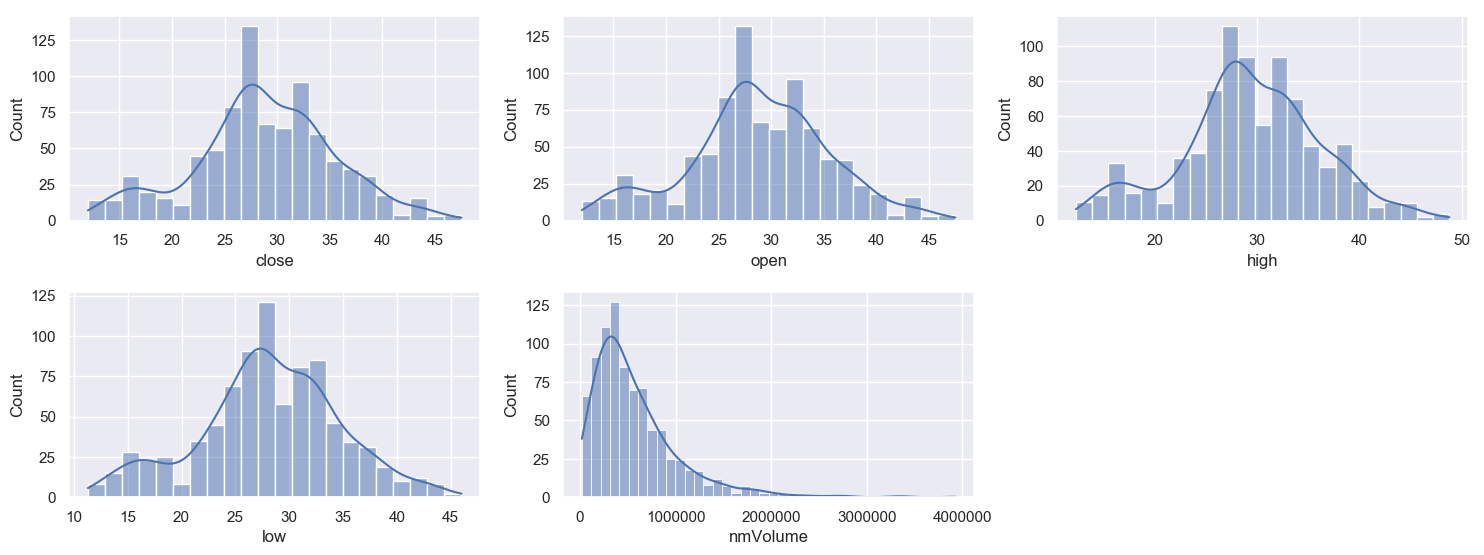

In [7]:
import seaborn as sns


sns.set_theme()

plt.subplots(figsize=(15,8))

for i, col in enumerate(features):  
  plt.subplot(3,3, i + 1)
  sns.histplot(d[col], kde=True)
  
plt.tight_layout()
plt.show()

In [22]:
from pandas import Grouper
from pandas import concat
from pandas import DataFrame

# Function for visualize box plot group by month in a specific year
def year_box_plot(data, y, code):
  one_year = data[data.index.year==y]
  groups = one_year.groupby(Grouper(freq='M'))

  months = concat([DataFrame(x[1].values) for x in groups], axis=1)
  months = DataFrame(months)
  months.columns = range(1,13)
  plt.figure(figsize=(20,8))
  months.boxplot()
  plt.xlabel('Month', size=20)
  plt.ylabel('Closed Price', size = 20)
  plt.title('Box and Whisker Plots by Month in year {} of {} code'.format(y,code), size=20)
  plt.show()

d:\Software\Anaconda\envs\speed_car\lib\site-packages\matplotlib\cbook\__init__.py:2116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


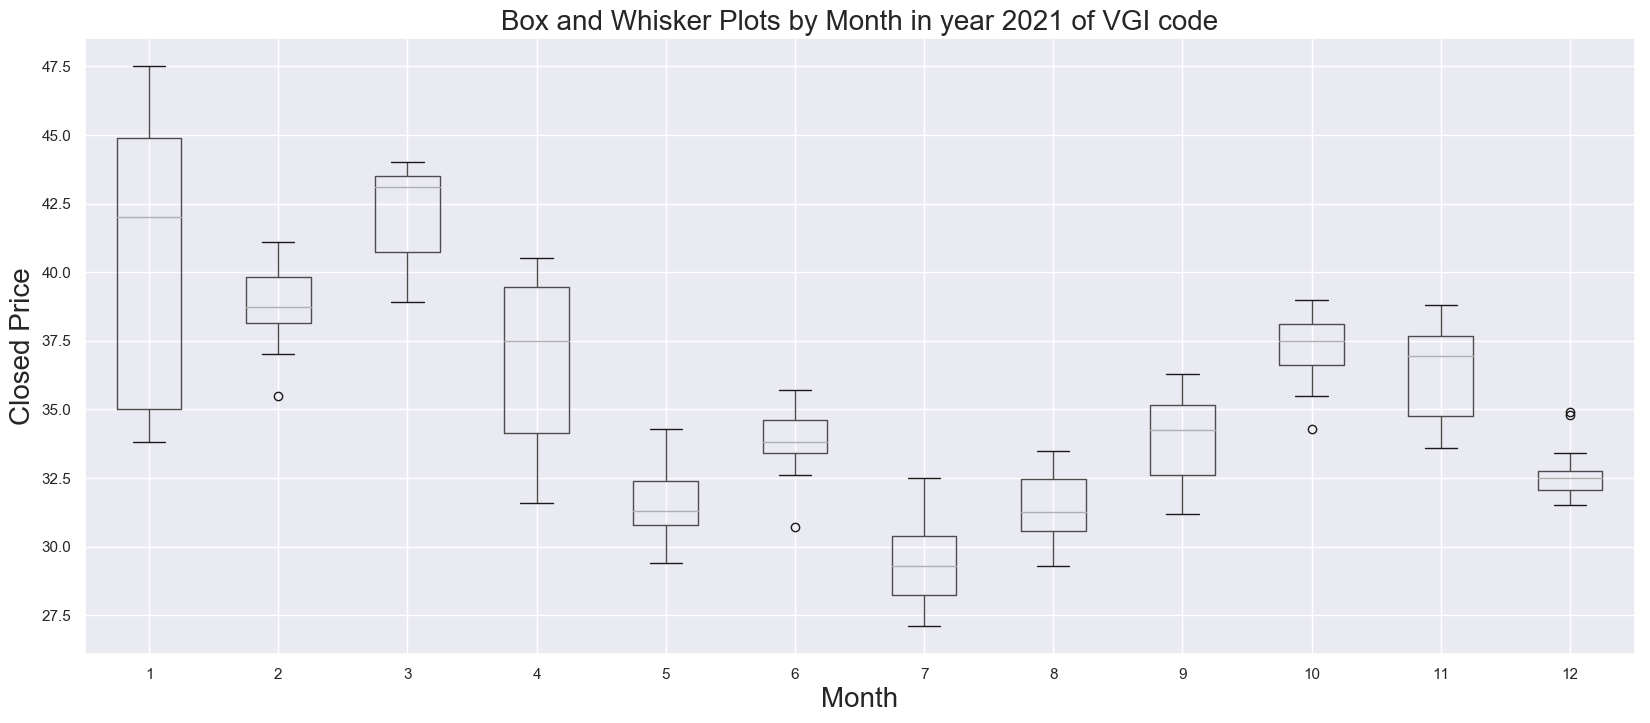

In [23]:
year_box_plot(d['close'], 2021, 'VGI')

In [24]:
from pandas import concat


def lag_plot(data):
  values = DataFrame(data.values)
  lags = 7
  columns = [values]
  for i in range(1,(lags + 1)):
    columns.append(values.shift(i))
  dataframe = concat(columns, axis=1)
  columns = ['t']
  for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
  dataframe.columns = columns
  plt.figure(figsize=(20,8))

  for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t vs t-' + str(i))
    plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)

  plt.show()

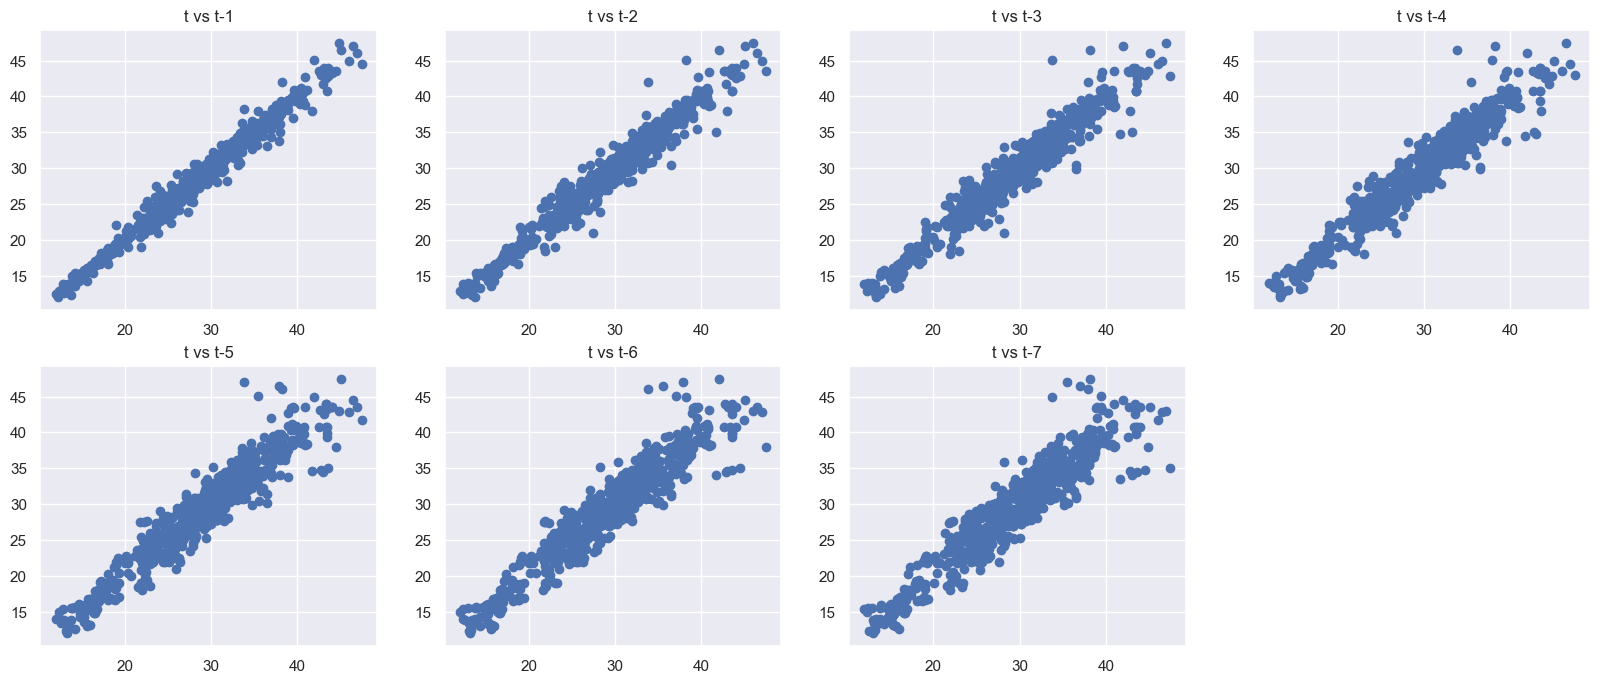

In [25]:
lag_plot(d['close'])

Split from the Dataset into Traing_set and Test_set (last two months). Training_set is split into train and validation (30% traning_set)

In [10]:
# Get the maximum date value
max_date = d.index.max()
print('max date:', max_date)
# Calculate the starting date for the last two months
start_date = max_date - pd.DateOffset(months=2)
print('start_date of last 2 months:', start_date)
print('pd.DateOffset(months=2)', pd.DateOffset(months=2))
# Filter the DataFrame for the last two months
last_two_months_data = d[d.index >= start_date]

# Print the last two months' data
print(last_two_months_data.head())

max date: 2021-12-31 00:00:00
start_date of last 2 months: 2021-10-31 00:00:00
pd.DateOffset(months=2) <DateOffset: months=2>
            close  open  high   low   nmVolume
date                                          
2021-11-01   38.7  39.1  39.8  38.5  1240132.0
2021-11-02   38.8  38.7  39.4  38.0  1602069.0
2021-11-03   37.5  38.8  39.0  37.5  1490049.0
2021-11-04   37.9  37.5  37.9  37.3   741502.0
2021-11-05   37.7  37.9  38.4  37.5   706210.0


In [11]:
test_set = last_two_months_data
test_set.shape

(45, 5)

In [23]:
test_set.to_csv('test_set.csv')

In [12]:
training_set= d[d.index < start_date]
training_set.shape


(809, 5)

In [25]:
training_set.to_csv('training_set.csv')

In [26]:
training_set

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0
...,...,...,...,...,...
2021-10-25,36.9,37.9,37.9,36.7,533523.0
2021-10-26,37.4,36.9,37.8,36.6,727721.0
2021-10-27,37.5,37.4,37.9,37.3,752737.0


In [27]:
test_set

,close,open,high,low,nmVolume
date,,,,,
2021-11-01,38.7,39.1,39.8,38.5,1240132.0
2021-11-02,38.8,38.7,39.4,38.0,1602069.0
2021-11-03,37.5,38.8,39.0,37.5,1490049.0
2021-11-04,37.9,37.5,37.9,37.3,741502.0
2021-11-05,37.7,37.9,38.4,37.5,706210.0
2021-11-08,37.7,37.5,38.0,37.2,952340.0
2021-11-09,37.6,37.5,37.9,37.3,821840.0
2021-11-10,37.3,37.6,37.9,37.2,690836.0
2021-11-11,36.6,37.4,37.5,36.3,1524668.0


In [13]:
def split_train_valid(train_data, valid_percent=0.3):
  lend = train_data.index.size
  spv = int(lend - valid_percent*lend)
  dpv = train_data.index[spv].strftime('%Y-%m-%d')
  print("Start date point validation:", dpv)
  train = train_data.iloc[:spv, :]
  valid = train_data.iloc[spv:, :]
  return train, valid

In [14]:
train, valid = split_train_valid(training_set)

Start date point validation: 2020-11-25


In [30]:
train.to_csv('train.csv')

In [31]:
valid.to_csv('valid.csv')

In [32]:
train

,close,open,high,low,nmVolume
date,,,,,
2018-09-25,21.0,21.0,21.0,16.0,1816800.0
2018-09-26,23.9,23.9,23.9,23.8,214200.0
2018-09-27,27.4,27.4,27.4,27.4,388100.0
2018-09-28,28.2,31.5,31.5,27.4,2111074.0
2018-10-01,26.8,29.5,29.6,25.8,831097.0
...,...,...,...,...,...
2020-11-18,27.7,28.0,28.2,27.6,286298.0
2020-11-19,28.0,27.8,28.0,27.7,334025.0
2020-11-20,29.7,28.0,30.0,28.0,2780883.0


In [33]:
valid

,close,open,high,low,nmVolume
date,,,,,
2020-11-25,30.7,31.7,32.0,30.6,1250785.0
2020-11-26,30.7,30.5,30.8,30.1,826967.0
2020-11-27,31.3,30.5,31.9,29.8,947845.0
2020-11-30,30.9,31.3,31.4,30.8,709841.0
2020-12-01,31.4,30.3,31.5,29.8,1235551.0
...,...,...,...,...,...
2021-10-25,36.9,37.9,37.9,36.7,533523.0
2021-10-26,37.4,36.9,37.8,36.6,727721.0
2021-10-27,37.5,37.4,37.9,37.3,752737.0


In [15]:
print('train shape:', train.shape) # 2018-09-25 --> 2020-11-24
print('valid shape:', valid.shape) # 2020-11-25 --> 2021-10-29
print('test shape:', test_set.shape) #2021-11-01 --> 2021-12-31

train shape: (566, 5)
valid shape: (243, 5)
test shape: (45, 5)


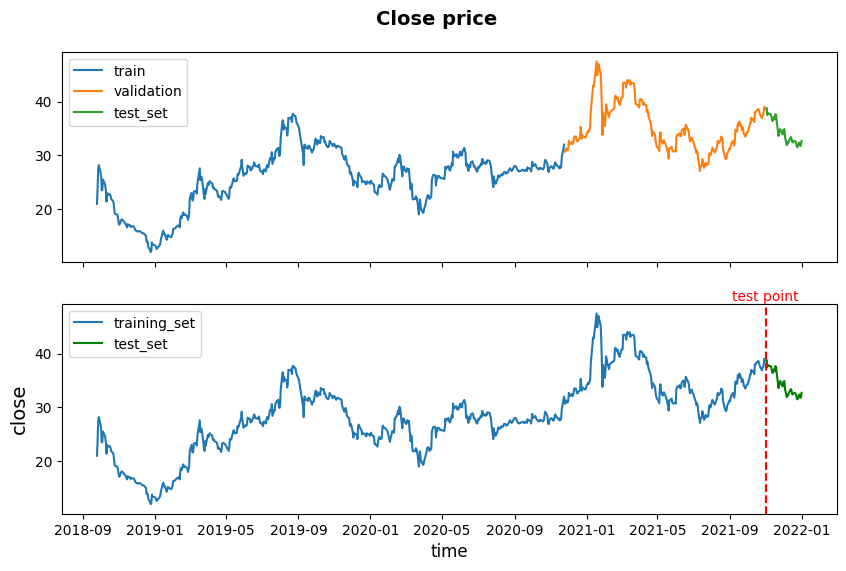

In [35]:
fig, ax = plt.subplots(2, sharex=True, sharey=True, figsize=(10, 6))
# plt.figure(figsize=(10, 6))

ax[0].plot(train['close'], label='train')
ax[0].plot(valid['close'], label='validation')
ax[0].plot(test_set['close'], label='test_set')
ax[1].plot(training_set['close'], label='training_set')
ax[1].plot(test_set['close'], label='test_set', color='green')

# test point 
test_point = start_date
# Plot the vertical line
ax[1].axvline(x=test_point, color='red', linestyle='--')
# Add a text annotation for the vertical line
plt.text(test_point, ax[1].get_ylim()[1] + 0.5, 'test point', color='red', ha='center')

# plt.title('Close price')
fig.suptitle('Close price', fontsize=14, fontweight='bold', y=0.95)
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('close', fontsize=14, horizontalalignment='center')
ax[0].legend()
ax[1].legend()

plt.show()

In [36]:
print('train shape: ', training_set.shape)
print('test shape: ', test_set.shape)


train shape:  (809, 5)
test shape:  (45, 5)


In [37]:
print('Last date of training_set', training_set.iloc[-1].name)
print('% test: ', test_set.shape[0]/(test_set.shape[0]+training_set.shape[0])*100, '%')

Last date of training_set 2021-10-29 00:00:00
% test:  5.269320843091335 %


Building Model

#1. Persistence Model

##Validation

In [16]:
# evaluate a persistence model

# walk-forward validation
history = [x for x in train['close']]
predictions = list()
for i in range(valid.shape[0]):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = valid.iloc[i, 0] # 0 là vị trị của close
    history.append(obs)
    print(i+1, 'predicted=%f, expected=%f' % (yhat, obs))

# report performance
evaluation_metric(valid['close'],predictions)

# GetMAPE(y_hat, y_test):
mape_persitence = GetMAPE(predictions, valid['close'])
print('mape_persitence : %.3f' % mape_persitence, '%' )

1 predicted=32.000000, expected=30.700000
2 predicted=30.700000, expected=30.700000
3 predicted=30.700000, expected=31.300000
4 predicted=31.300000, expected=30.900000
5 predicted=30.900000, expected=31.400000
6 predicted=31.400000, expected=32.700000
7 predicted=32.700000, expected=32.300000
8 predicted=32.300000, expected=32.100000
9 predicted=32.100000, expected=32.500000
10 predicted=32.500000, expected=32.100000
11 predicted=32.100000, expected=32.200000
12 predicted=32.200000, expected=32.700000
13 predicted=32.700000, expected=33.500000
14 predicted=33.500000, expected=33.500000
15 predicted=33.500000, expected=32.900000
16 predicted=32.900000, expected=32.600000
17 predicted=32.600000, expected=32.600000
18 predicted=32.600000, expected=32.900000
19 predicted=32.900000, expected=33.200000
20 predicted=33.200000, expected=35.300000
21 predicted=35.300000, expected=34.000000
22 predicted=34.000000, expected=33.100000
23 predicted=33.100000, expected=33.700000
24 predicted=33.7000

##Test

In [17]:
# evaluate a persistence model

# walk-forward test
history = [x for x in training_set['close']]
predictions = list()
for i in range(test_set.shape[0]):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test_set.iloc[i, 0] # 0 là vị trị của close
    history.append(obs)
    print(i+1, 'predicted=%f, expected=%f' % (yhat, obs))

# report performance
evaluation_metric(test_set['close'],predictions)

# GetMAPE(y_hat, y_test):
mape_persitence_test = GetMAPE(predictions, test_set['close'])
print('mape_persitence_test : %.3f' % mape_persitence_test, '%' )

1 predicted=39.000000, expected=38.700000
2 predicted=38.700000, expected=38.800000
3 predicted=38.800000, expected=37.500000
4 predicted=37.500000, expected=37.900000
5 predicted=37.900000, expected=37.700000
6 predicted=37.700000, expected=37.700000
7 predicted=37.700000, expected=37.600000
8 predicted=37.600000, expected=37.300000
9 predicted=37.300000, expected=36.600000
10 predicted=36.600000, expected=36.400000
11 predicted=36.400000, expected=37.200000
12 predicted=37.200000, expected=36.700000
13 predicted=36.700000, expected=37.700000
14 predicted=37.700000, expected=37.400000
15 predicted=37.400000, expected=36.300000
16 predicted=36.300000, expected=33.600000
17 predicted=33.600000, expected=34.600000
18 predicted=34.600000, expected=34.600000
19 predicted=34.600000, expected=34.900000
20 predicted=34.900000, expected=34.400000
21 predicted=34.400000, expected=33.900000
22 predicted=33.900000, expected=34.700000
23 predicted=34.700000, expected=34.800000
24 predicted=34.8000

#2. ARIMA on close

##Grid Search for ARIMA order

In [41]:
# grid search ARIMA parameters for time series
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(train_set, valid_set, arima_order):

    # walk-forward validation
    history = [x for x in train_set['close']]
    # make predictions
    predictions = list()
    for t in range(valid_set.shape[0]):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit()

        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = valid_set.iloc[t, 0] # 0 là vị trị của close
        history.append(obs)
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(valid_set['close'], predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train_set, valid_set, p_values, d_values, q_values):
    train_set['close'] = train_set['close'].astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(train_set, valid_set, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0,5)
d_values = range(0, 2)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(train, valid, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=9.242
ARIMA(0, 0, 1) RMSE=4.914
ARIMA(0, 1, 0) RMSE=1.026
ARIMA(0, 1, 1) RMSE=1.028
ARIMA(0, 1, 2) RMSE=1.034
ARIMA(0, 1, 3) RMSE=1.038
ARIMA(0, 1, 4) RMSE=1.039
ARIMA(1, 0, 0) RMSE=1.029
ARIMA(1, 0, 1) RMSE=1.031
ARIMA(1, 1, 0) RMSE=1.028
ARIMA(2, 0, 0) RMSE=160.837
ARIMA(2, 0, 1) RMSE=1.035
ARIMA(2, 1, 0) RMSE=1.034
ARIMA(2, 1, 1) RMSE=1.038
ARIMA(3, 0, 0) RMSE=1.037
ARIMA(3, 1, 0) RMSE=1.039
ARIMA(3, 1, 1) RMSE=1.035
ARIMA(3, 1, 2) RMSE=1.055
ARIMA(4, 0, 0) RMSE=1.041
ARIMA(4, 1, 0) RMSE=1.041
ARIMA(4, 1, 1) RMSE=1.043
ARIMA(4, 1, 2) RMSE=1.039
ARIMA(4, 1, 3) RMSE=1.048
Best ARIMA(0, 1, 0) RMSE=1.026


In [ ]:
# Results from Grid Search
# ARIMA(0, 0, 0) RMSE=9.242
# ARIMA(0, 0, 1) RMSE=4.914
# ARIMA(0, 1, 0) RMSE=1.026
# ARIMA(0, 1, 1) RMSE=1.028
# ARIMA(0, 1, 2) RMSE=1.034
# ARIMA(0, 1, 3) RMSE=1.038
# ARIMA(0, 1, 4) RMSE=1.039
# ARIMA(1, 0, 0) RMSE=1.029
# ARIMA(1, 0, 1) RMSE=1.031
# ARIMA(1, 1, 0) RMSE=1.028
# ARIMA(2, 0, 0) RMSE=160.837
# ARIMA(2, 0, 1) RMSE=1.035
# ARIMA(2, 1, 0) RMSE=1.034
# ARIMA(2, 1, 1) RMSE=1.038
# ARIMA(3, 0, 0) RMSE=1.037
# ARIMA(3, 1, 0) RMSE=1.039
# ARIMA(3, 1, 1) RMSE=1.035
# ARIMA(3, 1, 2) RMSE=1.055
# ARIMA(4, 0, 0) RMSE=1.041
# ARIMA(4, 1, 0) RMSE=1.041
# ARIMA(4, 1, 1) RMSE=1.043
# ARIMA(4, 1, 2) RMSE=1.039
# ARIMA(4, 1, 3) RMSE=1.048
# Best ARIMA(0, 1, 0) RMSE=1.026

In [13]:
# Best parameter on validation (0, 1, 0) with RMSE = 1.026
# we get that parameter to train model on all training set
# fit model
model = ARIMA(training_set['close'], order=(0,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# save model
model_fit.save('model_ARIMA.pkl')
from statsmodels.tsa.arima_model import ARIMAResults
# load model
model_fit_loaded = ARIMAResults.load('model_ARIMA.pkl')

d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  808
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1055.657
Method:                           css   S.D. of innovations              0.894
Date:                Fri, 26 May 2023   AIC                           2115.315
Time:                        01:16:57   BIC                           2124.704
Sample:                    09-26-2018   HQIC                          2118.920
                         - 10-29-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0223      0.031      0.709      0.479      -0.039       0.084


##ACF and PACF plot for ARIMA order

In [18]:
# temp = np.array(training_set['close'])
temp = np.array(train['close'])


In [19]:

# First-order diff
# training_set['diff_1'] = training_set['close'].diff(1)
train['diff_1'] = train['close'].diff(1)

# training_set.dropna(inplace=True)

d:\Software\Anaconda\envs\penguin\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


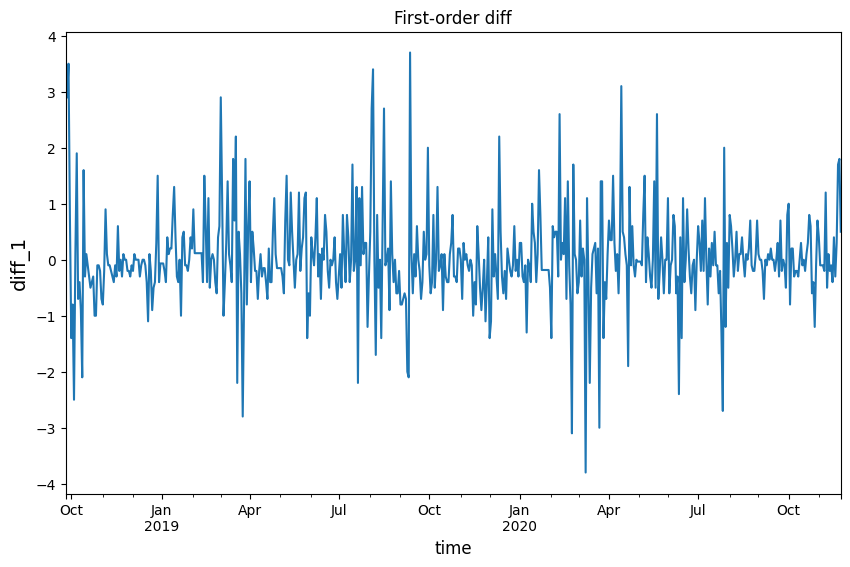

In [24]:
plt.figure(figsize=(10, 6))
# training_set['diff_1'].plot()
train['diff_1'].plot()

plt.title('First-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_1', fontsize=14, horizontalalignment='center')
plt.show()




In [20]:
# Second-order diff
# training_set['diff_2'] = training_set['diff_1'].diff(1)
train['diff_2'] = train['diff_1'].diff(1)

# train.dropna(inplace=True)

d:\Software\Anaconda\envs\penguin\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


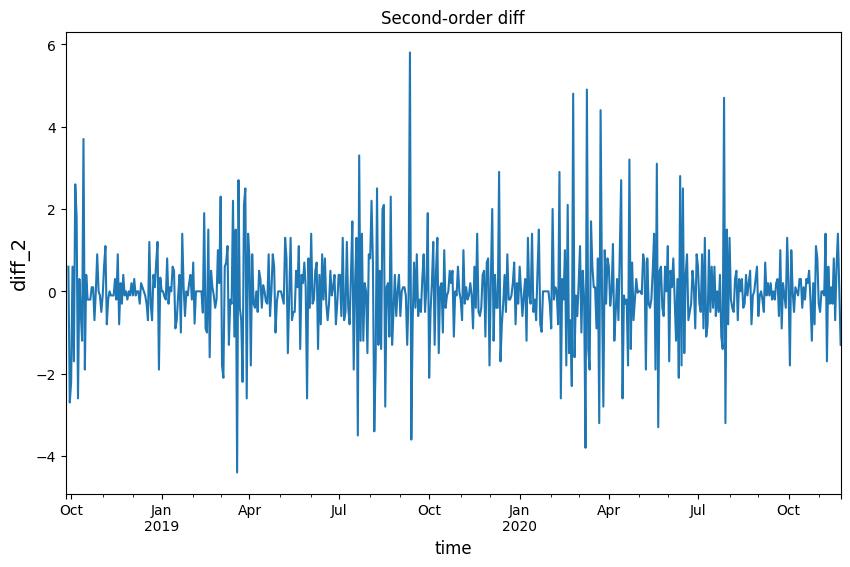

In [47]:
plt.figure(figsize=(10, 6))
# training_set['diff_2'].plot()
train['diff_2'].plot()

plt.title('Second-order diff')
plt.xlabel('time', fontsize=12, verticalalignment='top')
plt.ylabel('diff_2', fontsize=14, horizontalalignment='center')
plt.show()

In [49]:
temp2 = np.diff(train['close'], n=1)
lag = 10  # Number of lags to consider
lb_stat, lb_p_value = acorr_ljungbox(temp2, lags=lag)
for lag, p_value in enumerate(lb_p_value, start=1):
    if p_value < 0.05:
        print(f"Lag {lag}: p-value = {p_value} (significant autocorrelation)")
    else:
        print(f"Lag {lag}: p-value = {p_value} (no significant autocorrelation)")


# # all p-value > 0.05, white noise time-seriess after diff 1

Lag 1: p-value = 0.5483941896091388 (no significant autocorrelation)
Lag 2: p-value = 0.33405393609457357 (no significant autocorrelation)
Lag 3: p-value = 0.3571248463626978 (no significant autocorrelation)
Lag 4: p-value = 0.33834334661609494 (no significant autocorrelation)
Lag 5: p-value = 0.42120179476829045 (no significant autocorrelation)
Lag 6: p-value = 0.4977804186947875 (no significant autocorrelation)
Lag 7: p-value = 0.5909791851070832 (no significant autocorrelation)
Lag 8: p-value = 0.683929020644698 (no significant autocorrelation)
Lag 9: p-value = 0.7546451969920116 (no significant autocorrelation)
Lag 10: p-value = 0.32403399544726175 (no significant autocorrelation)


In [50]:
def kpss_test(x): # H0: stationary
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
    return results

In [51]:
adf_test(train['close']) # p>0.05, nonstationary

                               value
Test Statistic Value         -1.7633
p-value                      0.39883
Lags Used                          0
Number of Observations Used      565
Critical Value(1%)          -3.44198
Critical Value(5%)          -2.86667
Critical Value(10%)          -2.5695


In [52]:
kpss_test(train['close']) # p-value < 0.05, nonstationary

Test Statistic            1.006547
p-value                   0.010000
# of Lags                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

In [53]:
adf_test(train['diff_1'].dropna()) # p-value < 0.05, stationary

                               value
Test Statistic Value        -23.3602
p-value                            0
Lags Used                          0
Number of Observations Used      564
Critical Value(1%)            -3.442
Critical Value(5%)          -2.86668
Critical Value(10%)         -2.56951


In [54]:
kpss_test(train['diff_1'].dropna()) # p-value > 0.05, stationary


Test Statistic            0.058894
p-value                   0.100000
# of Lags                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

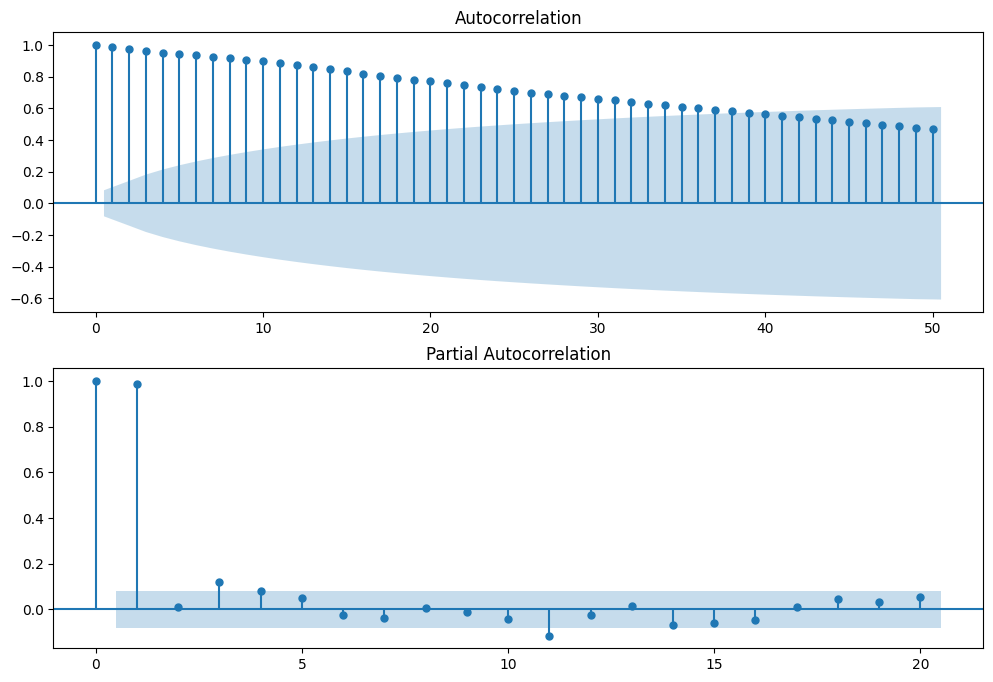

In [55]:

acf_pacf_plot(train['close'],acf_lags=50)




In [21]:
temp1 = np.diff(train['close'], n=1)  # n = 1,  lấy diff 1 lần, auto remove nan value, numpy arr

In [22]:
price = list(temp1)
data2 = {
    'date': train['diff_1'].index[1:],  # start = 1 if 0 is NA
    'close': price
}

&             close
date             
2018-09-26    2.9
2018-09-27    3.5
2018-09-28    0.8
2018-10-01   -1.4
2018-10-02   -0.8
...           ...
2020-11-18   -0.3
2020-11-19    0.3
2020-11-20    1.7
2020-11-23    1.8
2020-11-24    0.5

[565 rows x 1 columns]


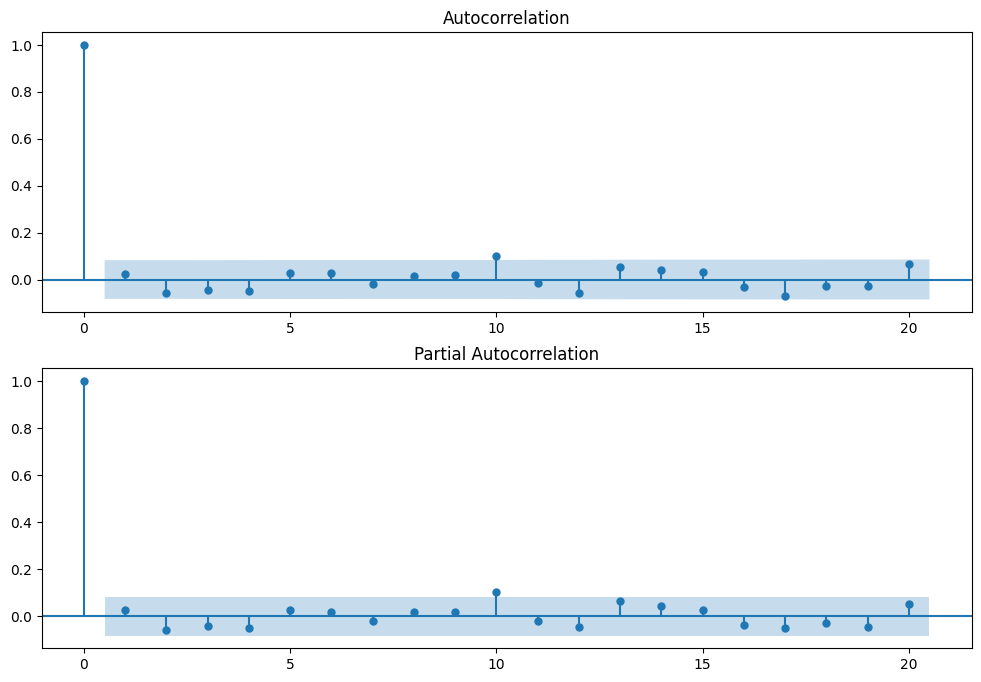

In [23]:
df = pd.DataFrame(data2)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

training_data_diff = df.set_index(['date'], drop=True)
print('&', training_data_diff)

acf_pacf_plot(training_data_diff)

In [24]:
order_select_ic(training_data_diff=training_data_diff) 
# best ar and ma are (0, 0) return by sm.tsa.arma_order_select_ic(training_data_diff, max_ar=6, max_ma=4, ic='bic') 

d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\Software\A

0 0


In [25]:
order_select_search(training_set=train) 
# own function return best ar and ma are (0, 0) in range max_p = 5 and max_q = 5

^ 5 ^^ 5


d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be 

p and q: 0,0


In [26]:
# order=(p,d,q)
model = sm.tsa.ARIMA(endog=train['close'], order=(0, 1, 0)).fit()
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  565
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -697.038
Method:                           css   S.D. of innovations              0.831
Date:                Sat, 27 May 2023   AIC                           1398.077
Time:                        15:06:07   BIC                           1406.750
Sample:                    09-26-2018   HQIC                          1401.462
                         - 11-24-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0195      0.035      0.557      0.578      -0.049       0.088


d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


##ARIMA on Validation

In [27]:
history = [x for x in train['close']]
# print('history', type(history), history)
predictions = list()
# print('test_set.shape', test_set.shape[0])
for t in range(valid.shape[0]):
    model1 = sm.tsa.ARIMA(history, order=(0, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = np.float(yhat[0])
    predictions.append(yhat)
    obs = valid.iloc[t, 0]  # 0 là vị trị của close
    # obs = np.float(obs)
    # print('obs', type(obs))
    history.append(obs)
    # print(test_set.index[t])
    print(t+1, 'predicted=%f, expected=%f' % (yhat, obs))
# print('predictions', predictions)

1 predicted=32.019469, expected=30.700000
2 predicted=30.717138, expected=30.700000
3 predicted=30.717108, expected=31.300000
4 predicted=31.318134, expected=30.900000
5 predicted=30.917399, expected=31.400000
6 predicted=31.418246, expected=32.700000
7 predicted=32.720490, expected=32.300000
8 predicted=32.319755, expected=32.100000
9 predicted=32.119372, expected=32.500000
10 predicted=32.520035, expected=32.100000
11 predicted=32.119304, expected=32.200000
12 predicted=32.219444, expected=32.700000
13 predicted=32.720277, expected=33.500000
14 predicted=33.521626, expected=33.500000
15 predicted=33.521589, expected=32.900000
16 predicted=32.920517, expected=32.600000
17 predicted=32.619966, expected=32.600000
18 predicted=32.619931, expected=32.900000
19 predicted=32.920412, expected=33.200000
20 predicted=33.220890, expected=35.300000
21 predicted=35.324444, expected=34.000000
22 predicted=34.022184, expected=33.100000
23 predicted=33.120613, expected=33.700000
24 predicted=33.7215

d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


38 predicted=43.637542, expected=44.500000
39 predicted=44.538972, expected=47.500000
40 predicted=47.543874, expected=44.900000
41 predicted=44.939504, expected=46.000000
42 predicted=46.041254, expected=47.000000
43 predicted=47.042834, expected=46.500000
44 predicted=46.541941, expected=45.100000
45 predicted=45.139573, expected=42.000000
46 predicted=42.034426, expected=38.200000
47 predicted=38.228151, expected=33.800000
48 predicted=33.820915, expected=37.900000
49 predicted=37.927569, expected=35.500000
50 predicted=35.523616, expected=37.000000
51 predicted=37.026016, expected=39.500000
52 predicted=39.530032, expected=39.000000
53 predicted=39.029173, expected=38.300000
54 predicted=38.327994, expected=37.100000
55 predicted=37.126010, expected=37.900000
56 predicted=37.927258, expected=38.050000
57 predicted=38.077456, expected=38.200000
58 predicted=38.227653, expected=38.350000
59 predicted=38.377849, expected=38.500000
60 predicted=38.528045, expected=38.650000
61 predicte

d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


210 predicted=34.417313, expected=36.000000
211 predicted=36.019355, expected=35.800000
212 predicted=35.819072, expected=35.500000
213 predicted=35.518662, expected=36.300000
214 predicted=36.319666, expected=35.400000
215 predicted=35.418485, expected=34.700000
216 predicted=34.717564, expected=35.200000
217 predicted=35.218182, expected=35.000000
218 predicted=35.017903, expected=34.100000
219 predicted=34.116731, expected=33.500000
220 predicted=33.515944, expected=33.900000
221 predicted=33.916433, expected=34.200000
222 predicted=34.216794, expected=34.300000
223 predicted=34.316900, expected=34.300000
224 predicted=34.316878, expected=35.500000
225 predicted=35.518378, expected=36.100000
226 predicted=36.119114, expected=36.100000
227 predicted=36.119090, expected=37.000000
228 predicted=37.020202, expected=36.600000
229 predicted=36.619672, expected=36.700000
230 predicted=36.719773, expected=36.200000
231 predicted=36.219119, expected=38.000000
232 predicted=38.021357, expecte

In [29]:
evaluation_metric(valid['close'],predictions)
# (0,1,0)
# MSE: 1.05188
# RMSE: 1.02561
# MAE: 0.70380
# R2: 0.94587
# GetMAPE(y_hat, y_test):
mape_validation = GetMAPE(predictions, valid['close'])
print('mape_validation : %.3f' % mape_validation, '%' )


MSE: 1.05188
RMSE: 1.02561
MAE: 0.70380
R2: 0.94587
mape_validation : 1.988 %


In [30]:

predictions1 = {
    # 'trade_date': test_set.index[:],
    'date': valid.index[:],
    'close': predictions
}
predictions1 = pd.DataFrame(predictions1)
predictions1 = predictions1.set_index(['date'], drop=True)

predictions1

,close
date,
2020-11-25,32.019469
2020-11-26,30.717138
2020-11-27,30.717108
2020-11-30,31.318134
2020-12-01,30.917399
...,...
2021-10-25,37.520548
2021-10-26,36.919776
2021-10-27,37.420373


In [ ]:
predictions1.to_csv('./ARIMA_Validation.csv')

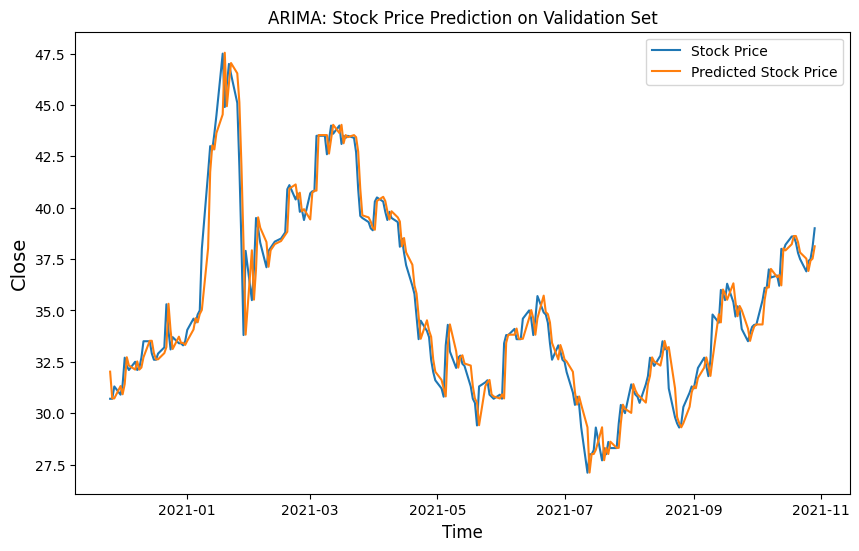

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(valid['close'], label='Stock Price')
plt.plot(predictions1, label='Predicted Stock Price')
plt.title('ARIMA: Stock Price Prediction on Validation Set')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

##Extract Residual feature

d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
d:\Software\Anaconda\envs\penguin\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


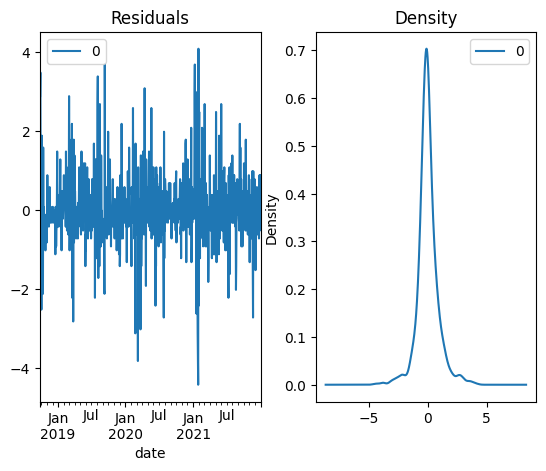

In [33]:

model2 = sm.tsa.ARIMA(endog=d['close'], order=(0, 1, 0)).fit()
residuals = pd.DataFrame(model2.resid)

fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
fig.subplots_adjust(wspace=0.25)  # Increase the spacing between the subplots

plt.show()

In [34]:
residuals.mean()

0    5.414452e-17
dtype: float64

In [35]:
residuals

,0
date,
2018-09-26,2.886284
2018-09-27,3.486284
2018-09-28,0.786284
2018-10-01,-1.413716
2018-10-02,-0.813716
...,...
2021-12-27,0.886284
2021-12-28,-0.513716
2021-12-29,-0.113716


In [ ]:
residuals.to_csv('./ARIMA_residuals1.csv')

##ARIMA on Test set

In [36]:
history2 = [x for x in training_set['close']]
# print('history', type(history), history)
predictions2 = list()
# print('test_set.shape', test_set.shape[0])
for t in range(test_set.shape[0]):
    model1 = sm.tsa.ARIMA(history2, order=(0, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()
    yhat = np.float(yhat[0])
    predictions2.append(yhat)
    obs = test_set.iloc[t, 0]  # 0 là vị trị của close
    # obs = np.float(obs)
    # print('obs', type(obs))
    history2.append(obs)
    # print(test_set.index[t])
    print(t+1, 'predicted=%f, expected=%f' % (yhat, obs))
# print('predictions', predictions)

1 predicted=39.022277, expected=38.700000
2 predicted=38.721879, expected=38.800000
3 predicted=38.821975, expected=37.500000
4 predicted=37.520345, expected=37.900000
5 predicted=37.920813, expected=37.700000
6 predicted=37.720541, expected=37.700000
7 predicted=37.720516, expected=37.600000
8 predicted=37.620368, expected=37.300000
9 predicted=37.319975, expected=36.600000
10 predicted=36.619094, expected=36.400000
11 predicted=36.418826, expected=37.200000
12 predicted=37.219780, expected=36.700000
13 predicted=36.719146, expected=37.700000
14 predicted=37.720341, expected=37.400000
15 predicted=37.419951, expected=36.300000
16 predicted=36.318591, expected=33.600000
17 predicted=33.615291, expected=34.600000
18 predicted=34.616485, expected=34.600000
19 predicted=34.616465, expected=34.900000
20 predicted=34.916808, expected=34.400000
21 predicted=34.416184, expected=33.900000
22 predicted=33.915561, expected=34.700000
23 predicted=34.716506, expected=34.800000
24 predicted=34.8166

In [37]:
evaluation_metric(test_set['close'],predictions2)
# (0, 1, 0)
# MSE: 0.53154
# RMSE: 0.72907
# MAE: 0.51793
# R2: 0.89888
# GetMAPE(y_hat, y_test):
mape_test = GetMAPE(predictions2, test_set['close'])
print('mape_test : %.3f' % mape_test, '%' )

MSE: 0.53154
RMSE: 0.72907
MAE: 0.51793
R2: 0.89888
mape_test : 1.510 %


In [38]:
predictions2 = {
    # 'trade_date': test_set.index[:],
    'date': test_set.index[:],
    'close': predictions2
}
predictions2 = pd.DataFrame(predictions2)
predictions2 = predictions2.set_index(['date'], drop=True)
predictions2

,close
date,
2021-11-01,39.022277
2021-11-02,38.721879
2021-11-03,38.821975
2021-11-04,37.520345
2021-11-05,37.920813
2021-11-08,37.720541
2021-11-09,37.720516
2021-11-10,37.620368
2021-11-11,37.319975


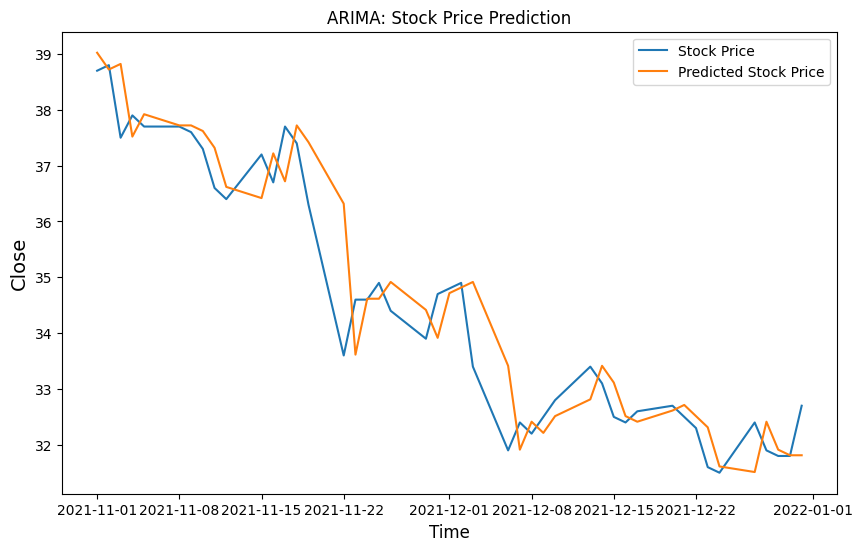

In [39]:

plt.figure(figsize=(10, 6))
plt.plot(test_set['close'], label='Stock Price')
plt.plot(predictions2, label='Predicted Stock Price')
plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

In [40]:
# Save predictions value on Test
predictions2.to_csv('./ARIMA.csv')

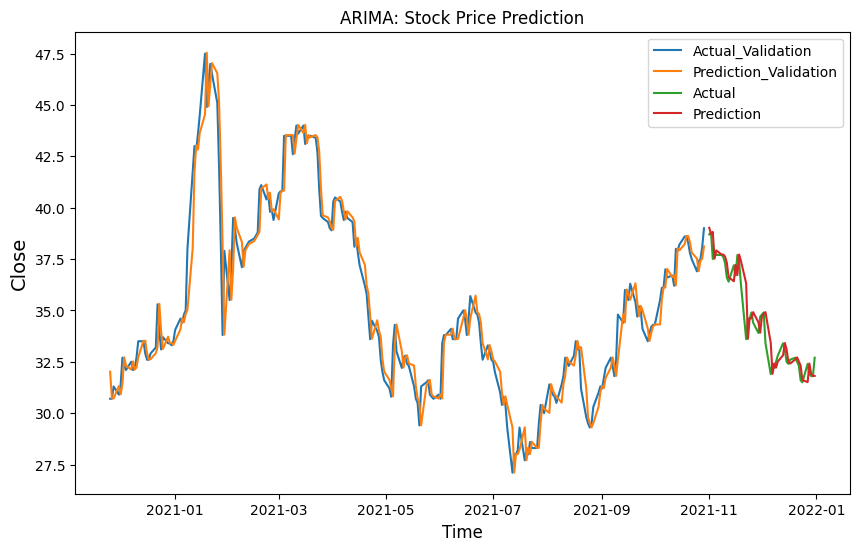

In [41]:
plt.figure(figsize=(10, 6))
# Plot the predictions and actual values on the validation set
# plt.plot(train.index, train['close'], label='train_set')


plt.plot(valid.index, valid['close'], label='Actual_Validation')
plt.plot(predictions1.index, predictions1['close'], label='Prediction_Validation')

# Plot the predictions and actual values on the test set
plt.plot(test_set.index, test_set['close'], label='Actual')
plt.plot(predictions2.index, predictions2['close'], label='Prediction')

# Customize the plot

plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time', fontsize=12, verticalalignment='top')
plt.ylabel('Close', fontsize=14, horizontalalignment='center')
plt.legend()
plt.show()

# Display the plot
plt.show()
